In [15]:
import datetime
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import (
    get_kelly, filter_leverage, get_cumulative_returns, backtest
)

In [22]:
start = datetime.date(2022, 1,3)
end = datetime.date(2022,11,4)

# Tesla, Morderna, Microsoft, Apple and Amazon
prices = web.DataReader(["TSLA","MRNA","MSFT","AAPL", "AMZN"], "yahoo", start, end)["Adj Close"]
prices = prices.dropna()
returns = prices.pct_change()
returns.head()

Symbols,TSLA,MRNA,MSFT,AAPL,AMZN
Date,,,,,
2022-01-03,NaN,NaN,NaN,NaN,NaN
2022-01-04,-0.041833,-0.008466,-0.017147,-0.012691,-0.016916
2022-01-05,-0.053471,-0.076504,-0.038388,-0.026600,-0.018893
2022-01-06,-0.021523,0.003856,-0.007902,-0.016693,-0.006711
2022-01-07,-0.035447,-0.010182,0.000510,0.000988,-0.004288


In [2]:
sp500 = pd.read_csv('sp500.csv', index_col='date', sep=";")

returns_sp500 = sp500['sp500'].pct_change()
shift_returns_sp500 = returns_sp500.shift(-1)

expanding_kelly = get_kelly(returns_sp500)

parameters_df = pd.DataFrame()
parameters_df['kelly'] = expanding_kelly
parameters_df['Next day return'] = shift_returns_sp500
parameters_df['mean'] = returns_sp500.expanding(400).mean() 

Text(0.5, 1.0, 'Kelly optimal $f^*$ prediction capacity')

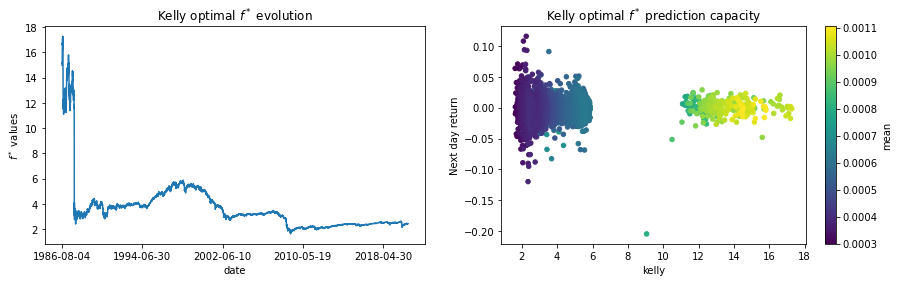

In [3]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

expanding_kelly.plot(ax=ax[0])
ax[0].set_ylabel('$f^*$ values');
ax[0].set_title('Kelly optimal $f^*$ evolution');

parameters_df.plot.scatter(
    x='kelly', y='Next day return', c='mean', colormap='viridis', ax=ax[1],
)
ax[1].set_title('Kelly optimal $f^*$ prediction capacity')

In [4]:
all_returns_df = pd.DataFrame()

# set the leverages for 1 to 5
leverages = range(1, 6)

# returns starting in the first day available
first_date = expanding_kelly.index[0]
shift_returns_sp500 = shift_returns_sp500[first_date:]

for leverage in leverages:
    filter_kelly = filter_leverage(expanding_kelly, leverage)
    
    name = 'max_leverage_' + str(leverage)    
    all_returns_df[name] = shift_returns_sp500 * filter_kelly
    
all_returns_df['SP500'] = shift_returns_sp500

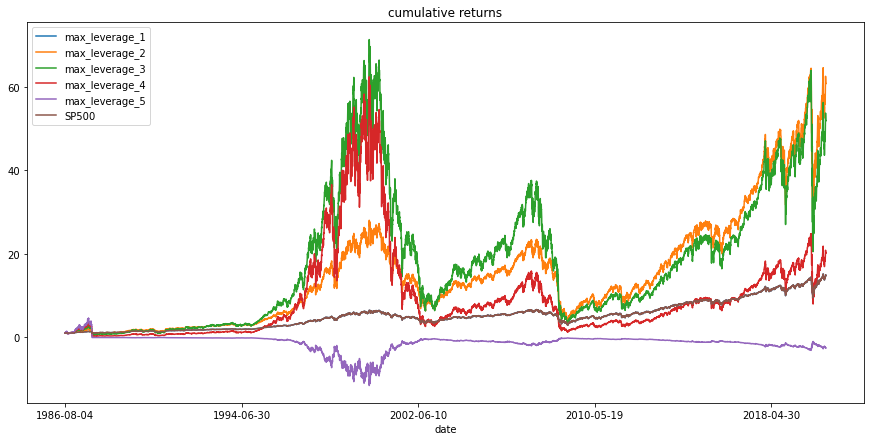

In [5]:
cum_returns = get_cumulative_returns(all_returns_df)

cum_returns.plot(figsize=(15, 7))
plt.title('cumulative returns');

In [6]:
companies_df = pd.read_csv('stocks.csv', index_col='date', sep=';')
returns_df = companies_df.pct_change()
shift_returns = returns_df.shift(-1)

<AxesSubplot:>

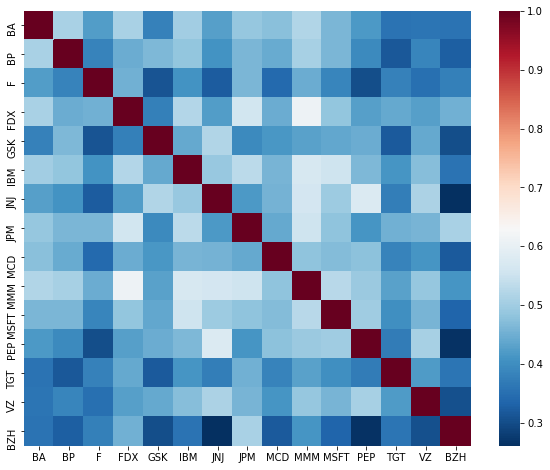

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(returns_df.corr(), cmap="RdBu_r")

In [8]:
# f* values for correlated securities
opt_correlated_kelly = get_kelly(returns_df, correlation=True)

# f* values for uncorrelated securities
opt_uncorrelated_kelly = get_kelly(returns_df, correlation=False)

# set parameters for the backtest
leverages = range(1, 6)
start_date = opt_correlated_kelly.index[0]
shift_returns = shift_returns[start_date:]

# make the backtest
total_returns_corr = backtest(opt_correlated_kelly, shift_returns, leverages)
total_returns_uncorr = backtest(opt_uncorrelated_kelly, shift_returns, leverages)

In [9]:
n_companies = len(shift_returns.columns)

# invest once and don't touch it again
cum_returns_ew = get_cumulative_returns(shift_returns)
cum_returns_ew = cum_returns_ew / n_companies
invest_once_equally_weight = cum_returns_ew.sum(axis=1)

# reinvest every day
total_returns_corr['reinvest_equally_weight'] = shift_returns.sum(axis=1) / n_companies
total_returns_uncorr['reinvest_equally_weight'] = shift_returns.sum(axis=1) / n_companies

# cumulative returns for correlated securities
cum_returns_corr = get_cumulative_returns(total_returns_corr)
cum_returns_corr['invest_once_equally_weight'] = invest_once_equally_weight

# cumulative returns for uncorrelated securities
cum_returns_uncorr = get_cumulative_returns(total_returns_uncorr)
cum_returns_uncorr['invest_once_equally_weight'] = invest_once_equally_weight

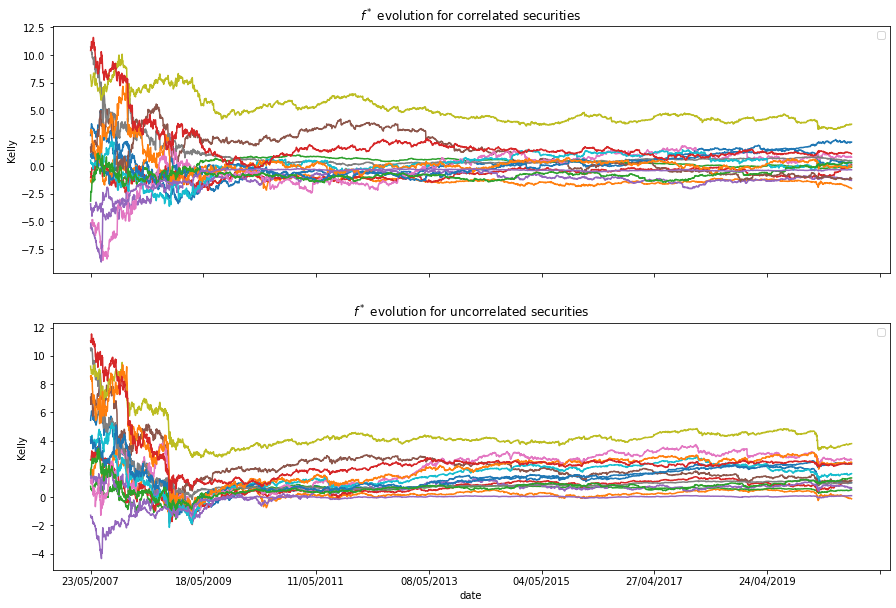

In [10]:
fig, ax = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)

opt_correlated_kelly.plot(ax=ax[0])
ax[0].set_title('$f^*$ evolution for correlated securities');
ax[0].set_ylabel('Kelly');
ax[0].legend([]);

opt_uncorrelated_kelly.plot(ax=ax[1])
ax[1].set_title('$f^*$ evolution for uncorrelated securities');
ax[1].set_ylabel('Kelly');
ax[1].legend([]);

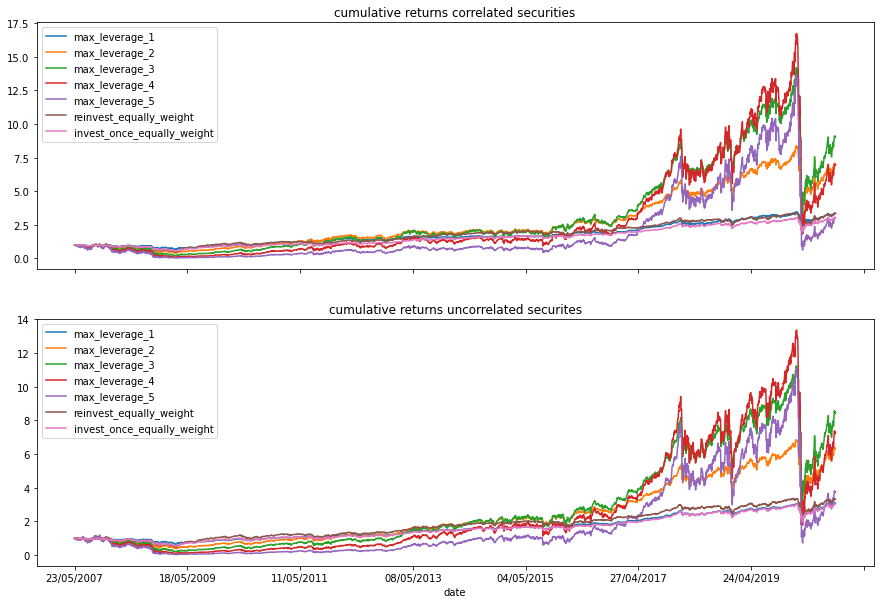

In [11]:
fig, ax = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)

cum_returns_corr.plot(ax=ax[0])
ax[0].set_title('cumulative returns correlated securities');

cum_returns_uncorr.plot(ax=ax[1])
ax[1].set_title('cumulative returns uncorrelated securites');